In [27]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [3]:
# import deeplake
# ds = deeplake.load("hub://activeloop/ffhq")
# ds.summary()
# print(ds.tensors['images_128/image'].shape)

In [4]:
dirpath = 'images/thumbnails_jpg'
filenames = os.listdir(dirpath)
N_IMGS = 100
img_paths = [dirpath + f"/{filename}" for filename in filenames[:N_IMGS]]
print(f"Keeping {len(img_paths)} images out of {len(filenames)}")

Keeping 100 images out of 70000


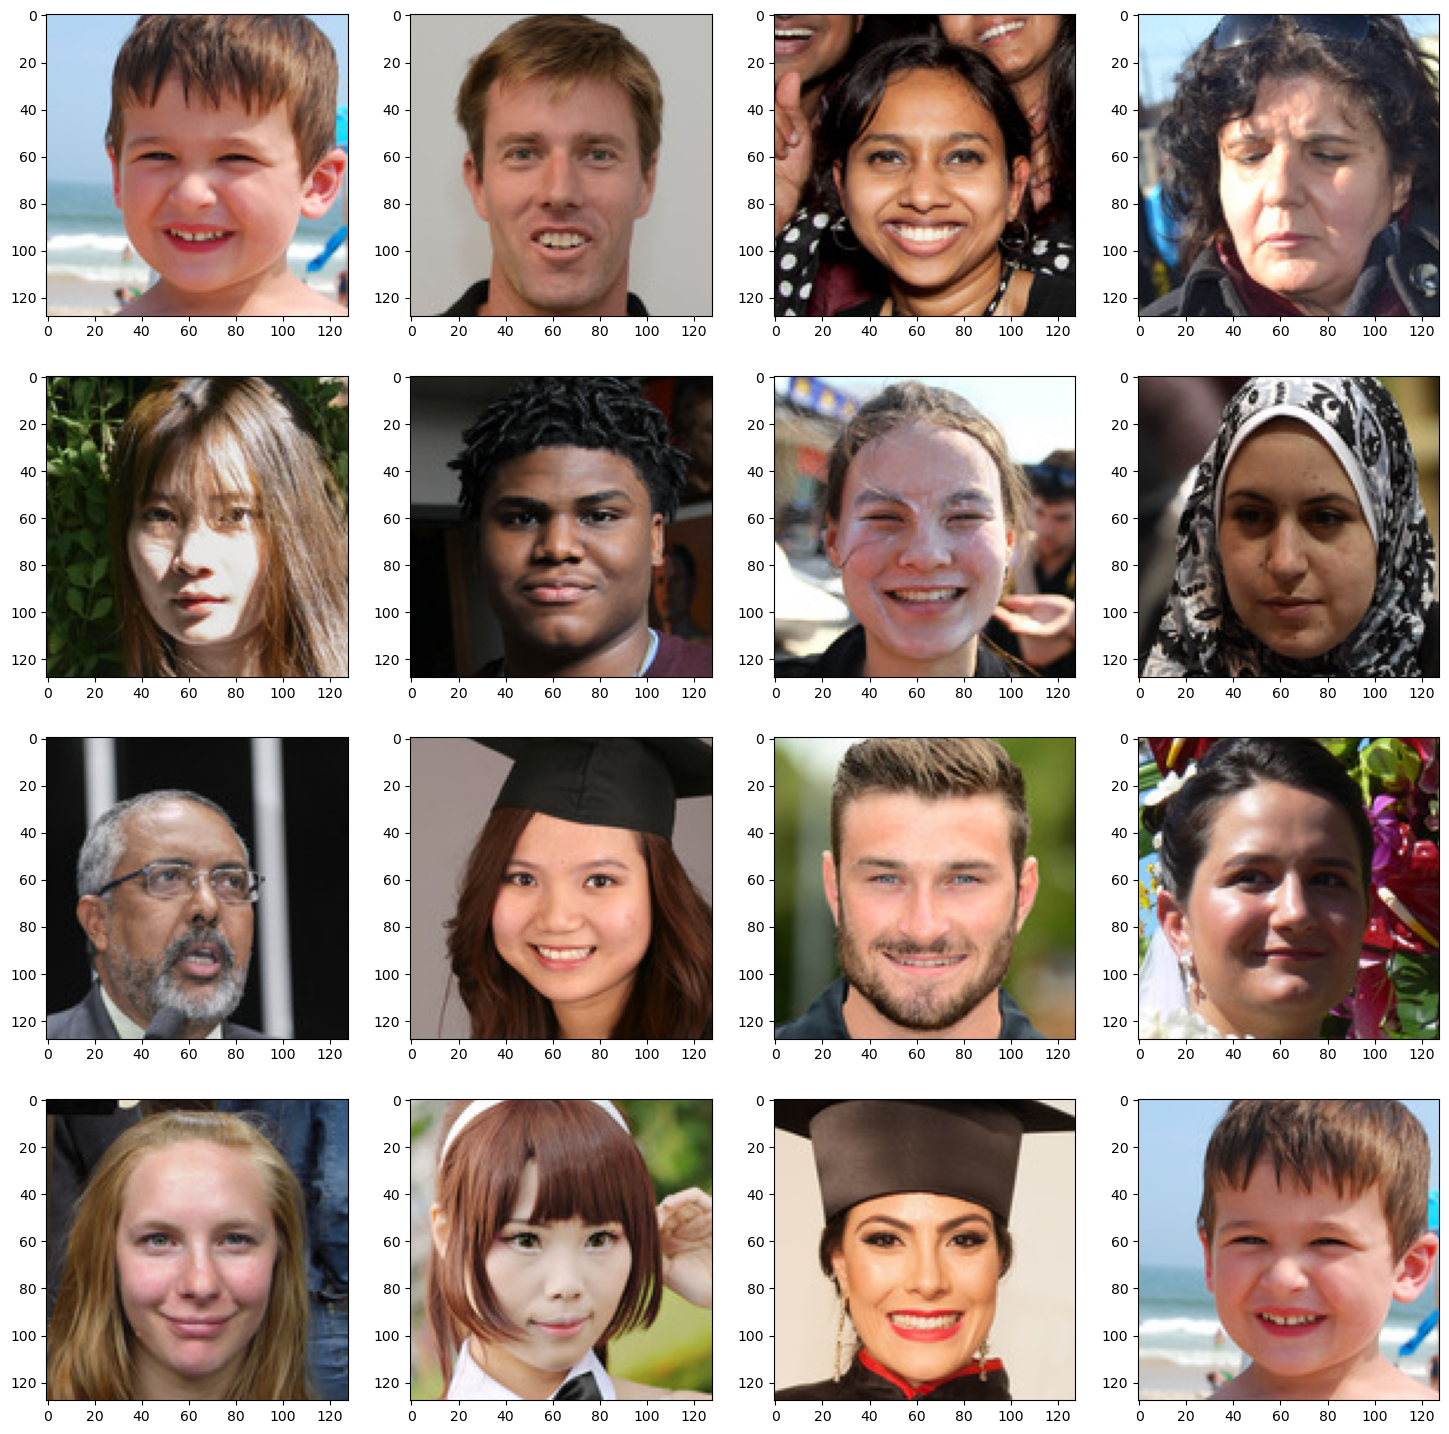

In [5]:
fix, axes = plt.subplots(4, 4, figsize=(18, 18))
samples = [img_paths[i] for i in np.random.randint(0, N_IMGS, size=16)]
for i, sample in enumerate(samples):
    image = cv2.imread(sample)
    axes.flat[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
H, W = 128, 128  # Not sure if H, W or W, h
X = np.zeros((N_IMGS, 128, 128, 3), dtype=np.uint8)
for i, path in tqdm(enumerate(img_paths), total=N_IMGS):
    img = cv2.imread(path)
    X[i] = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 473.91it/s]


In [29]:
from keras.layers import Conv2D, UpSampling2D, InputLayer
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint

In [31]:
# model = Sequential()
# model.add(InputLayer(input_shape=(128, 128, 1)))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))
# model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
# model.add(UpSampling2D((2, 2)))

# Easier, baseline model
model = Sequential()
model.add(InputLayer(input_shape=(128, 128, 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

model.compile(optimizer='adam', loss='mse')

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 8)         80        
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 8)         584       
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 16)        1168      
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 16)        2320      
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 up_sampling2d_3 (UpSampling  (None, 32, 32, 32)      

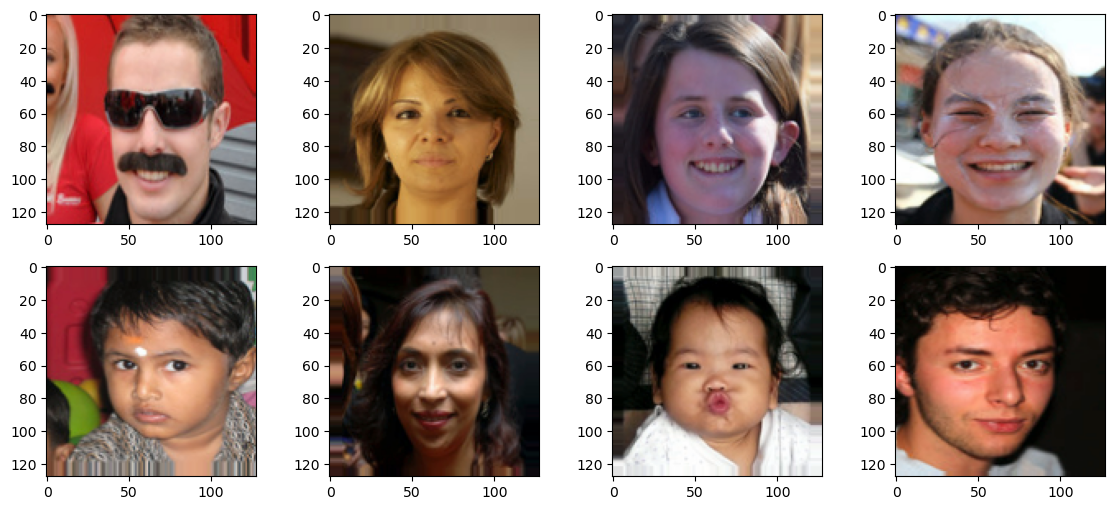

In [10]:
# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        # rotation_range=20,
        horizontal_flip=True)

# Generate training data
def image_gen(X, batch_size):
    for batch in datagen.flow(X, batch_size=batch_size):
        lab_batch = [cv2.cvtColor(img, cv2.COLOR_BGR2Lab) for img in batch]
        lab_batch = np.array(lab_batch)
        # Input: Keeping L channel
        X_batch = lab_batch[:, :, :, 0][:, :, :, np.newaxis]  
        # Target: Keeping a and b channels
        Y_batch = lab_batch[:, :, :, 1:]
        yield X_batch, Y_batch / 128

# Display some examples of transformation
fix, axes = plt.subplots(2, 4, figsize=(14, 6))
for i in range(8):
    image = cv2.cvtColor(next(datagen.flow(X, batch_size=1))[0].astype(np.uint8), cv2.COLOR_Lab2RGB)
    axes.flat[i].imshow(image)
plt.show()

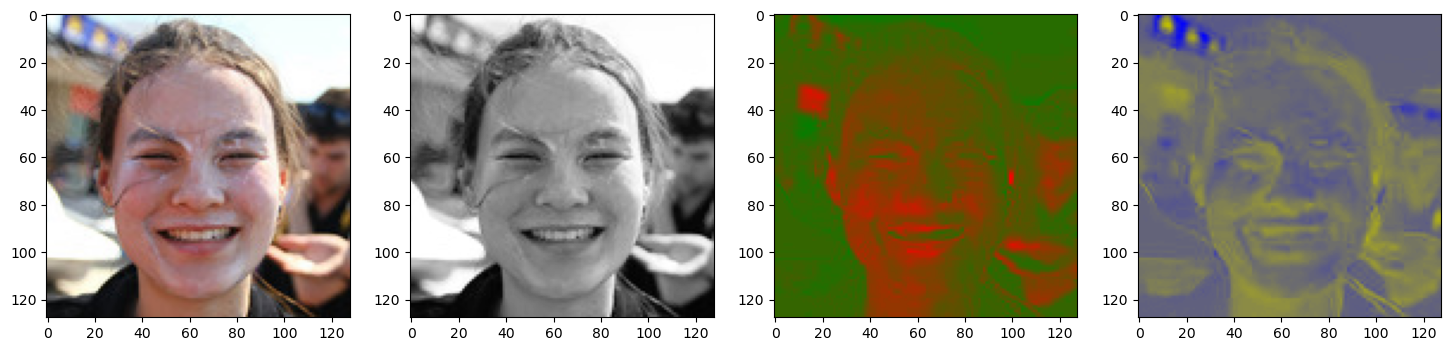

In [11]:
from  matplotlib.colors import LinearSegmentedColormap
cmap_a=LinearSegmentedColormap.from_list('gr',["g", "r"], N=256) 
cmap_b=LinearSegmentedColormap.from_list('by',["b", "y"], N=256) 

sample = cv2.imread(img_paths[4])
fig, axes = plt.subplots(1, 4, figsize=(18, 6))
axes[0].imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
axes[1].imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2Lab)[:, :, 0], cmap='gray')
axes[2].imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2Lab)[:, :, 1], cmap=cmap_a)
axes[3].imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2Lab)[:, :, 2], cmap=cmap_b);

In [30]:
log_dir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint = ModelCheckpoint('checkpoints/', save_weights_only=True)

In [ ]:
if IN_COLAB:
    %load_ext tensorboard
    %tensorboard --logdir logs
# else:
# Run in command line in conda env:
# tensorboard --logdir logs/

In [26]:
model.fit(image_gen(X, batch_size=64), epochs=10, steps_per_epoch=10000, callbacks=[tensorboard_callback, checkpoint], verbose=1)

Epoch 1/10
2/2 [==============================] - 18s 8s/step - loss: 1.0015
Epoch 2/10
2/2 [==============================] - 18s 7s/step - loss: 1.0015
Epoch 3/10
2/2 [==============================] - 16s 7s/step - loss: 1.0014
Epoch 4/10
2/2 [==============================] - 18s 7s/step - loss: 1.0013
Epoch 5/10
2/2 [==============================] - 19s 8s/step - loss: 1.0015
Epoch 6/10
2/2 [==============================] - 18s 7s/step - loss: 1.0013
Epoch 7/10
2/2 [==============================] - 18s 8s/step - loss: 1.0013
Epoch 8/10
2/2 [==============================] - 18s 7s/step - loss: 1.0014
Epoch 9/10
2/2 [==============================] - 18s 8s/step - loss: 1.0015
Epoch 10/10
2/2 [==============================] - 18s 7s/step - loss: 1.0015
